In [1]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from catboost import CatBoostRegressor, Pool, cv
import lightgbm as lgb
from IPython.display import display

from sklearn.model_selection import KFold
from sklearn import metrics
from datetime import datetime

import seaborn as sns

%matplotlib inline
pd.options.mode.chained_assignment = None
pd.set_option('display.float_format', lambda x: '%.3f' % x)
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

# sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [12, 8]})
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 8

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


### Custom Functions

In [2]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)
        
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

def get_stats(df,columns):
    fig, axs = plt.subplots(1,2)
    for column in columns:
        df2 = df[np.isfinite(df[column])]
        count, division = np.histogram(df2[column])
        null_value_stats = df[df[column].isnull()]
        print(f"Column name: {column}")
        print(f"Total Rows: {len(df)}")
        print(f"Positive values row count: {len(df[(df[column]>=0)])}")
        print(f"Negative values row count: {len(df[(df[column]<0)])}")
        print(f"Null values row count: {null_value_stats.shape[0]}")
        print(f"Column summary")
        print(df[column].describe())
        print(f"Cut: {division}")
        print(f"Count: {count}")
        df.boxplot(column=[column], ax=axs[0])
        df[column].plot.hist(bins=10, alpha=0.5, ax=axs[1])

def rmsle(real, predicted):
    sum=0.0
    for x in range(len(predicted)):
        if predicted[x]<0 or real[x]<0: #check for negative values
            continue
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        sum = sum + (p - r)**2
    return round(100*(sum/len(predicted))**0.5,3)

def calc_smooth_mean(df, by, on, m):
    # Compute the global mean
    mean = df[on].mean()

    # Compute the number of values and the mean of each group
    agg = df.groupby(by)[on].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']

    # Compute the "smoothed" means
    smooth = (counts * means + m * mean) / (counts + m)

    # Replace each value by the according smoothed mean
    return smooth

def get_count_encode(train,test,by_cols,on_col,name):
    temp=train.groupby(by_cols)[on_col].count().reset_index().rename(columns={on_col:name})
    train=pd.merge(train,temp,how='left',on=by_cols)
    test=pd.merge(test,temp,how='left',on=by_cols)
    train[name].fillna(np.median(temp[name]),inplace=True)
    test[name].fillna(np.median(temp[name]),inplace=True)
    return train,test

def get_mean_encode(train,test,by_cols,on_col,name):
    temp=train.groupby(by_cols)[on_col].mean().reset_index().rename(columns={on_col:name})
    train=pd.merge(train,temp,how='left',on=by_cols)
    test=pd.merge(test,temp,how='left',on=by_cols)
    train[name].fillna(np.median(temp[name]),inplace=True)
    test[name].fillna(np.median(temp[name]),inplace=True)
    return train,test

def remove_outliers(df, column):
    print(f'Original dataframe has {df.shape[0]} records')
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    low_fence = (Q1 - 1.5 * IQR)
    high_fence = (Q3 + 1.5 * IQR)
    df_out = df.loc[(df[column] > low_fence) & (df[column] < high_fence)]
    print(f'Processed dataframe has {df_out.shape[0]} records')
    print(f'Records discarded: {df.shape[0] - df_out.shape[0]}')
        
    return df_out

In [3]:
train_data = pd.read_csv('./data/food_forecasting/train_files/train.csv')

In [4]:
test_data = pd.read_csv('./data/food_forecasting/test.csv')

In [5]:
meal_data = pd.read_csv('./data/food_forecasting/train_files/meal_info.csv')

In [6]:
store_data = pd.read_csv('./data/food_forecasting/train_files/fulfilment_center_info.csv')

In [7]:
train_data  = pd.merge(train_data, meal_data, how="left",on='meal_id')

In [8]:
full_train  = pd.merge(train_data, store_data, how="left",on='center_id')

In [9]:
test_data  = pd.merge(test_data, meal_data, how="left",on='meal_id')

In [10]:
full_test  = pd.merge(test_data, store_data, how="left",on='center_id')
full_test['num_orders'] = np.nan

In [11]:
display_all(full_train.head())

id  week  center_id  meal_id  checkout_price  base_price  \
0  1379560     1         55     1885         136.830     152.290   
1  1466964     1         55     1993         136.830     135.830   
2  1346989     1         55     2539         134.860     135.860   
3  1338232     1         55     2139         339.500     437.530   
4  1448490     1         55     2631         243.500     242.500   

   emailer_for_promotion  homepage_featured  num_orders   category cuisine  \
0                      0                  0         177  Beverages    Thai   
1                      0                  0         270  Beverages    Thai   
2                      0                  0         189  Beverages    Thai   
3                      0                  0          54  Beverages  Indian   
4                      0                  0          40  Beverages  Indian   

   city_code  region_code center_type  op_area  
0        647           56      TYPE_C    2.000  
1        647           56      TYPE_C    2.000  
2        647           56      TYPE_C    2.000  
3        647           56      TYPE_C    2.000  
4        647           56      TYPE_C    2.000

In [12]:
full_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 456548 entries, 0 to 456547
Data columns (total 15 columns):
id                       456548 non-null int64
week                     456548 non-null int64
center_id                456548 non-null int64
meal_id                  456548 non-null int64
checkout_price           456548 non-null float64
base_price               456548 non-null float64
emailer_for_promotion    456548 non-null int64
homepage_featured        456548 non-null int64
num_orders               456548 non-null int64
category                 456548 non-null object
cuisine                  456548 non-null object
city_code                456548 non-null int64
region_code              456548 non-null int64
center_type              456548 non-null object
op_area                  456548 non-null float64
dtypes: float64(3), int64(9), object(3)
memory usage: 55.7+ MB


In [13]:
full_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32573 entries, 0 to 32572
Data columns (total 15 columns):
id                       32573 non-null int64
week                     32573 non-null int64
center_id                32573 non-null int64
meal_id                  32573 non-null int64
checkout_price           32573 non-null float64
base_price               32573 non-null float64
emailer_for_promotion    32573 non-null int64
homepage_featured        32573 non-null int64
category                 32573 non-null object
cuisine                  32573 non-null object
city_code                32573 non-null int64
region_code              32573 non-null int64
center_type              32573 non-null object
op_area                  32573 non-null float64
num_orders               0 non-null float64
dtypes: float64(4), int64(8), object(3)
memory usage: 4.0+ MB


In [14]:
full_train.describe()

id       week  center_id    meal_id  checkout_price  \
count  456548.000 456548.000 456548.000 456548.000      456548.000   
mean  1250096.306     74.769     82.106   2024.337         332.239   
std    144354.822     41.525     45.975    547.421         152.940   
min   1000000.000      1.000     10.000   1062.000           2.970   
25%   1124998.750     39.000     43.000   1558.000         228.950   
50%   1250183.500     76.000     76.000   1993.000         296.820   
75%   1375140.250    111.000    110.000   2539.000         445.230   
max   1499999.000    145.000    186.000   2956.000         866.270   

       base_price  emailer_for_promotion  homepage_featured  num_orders  \
count  456548.000             456548.000         456548.000  456548.000   
mean      354.157                  0.081              0.109     261.873   
std       160.716                  0.273              0.312     395.923   
min        55.350                  0.000              0.000      13.000   
25%       243.500                  0.000              0.000      54.000   
50%       310.460                  0.000              0.000     136.000   
75%       458.870                  0.000              0.000     324.000   
max       866.270                  1.000              1.000   24299.000   

       city_code  region_code    op_area  
count 456548.000   456548.000 456548.000  
mean     601.553       56.615      4.084  
std       66.196       17.641      1.092  
min      456.000       23.000      0.900  
25%      553.000       34.000      3.600  
50%      596.000       56.000      4.000  
75%      651.000       77.000      4.500  
max      713.000       93.000      7.000

In [15]:
numerical = full_train._get_numeric_data().columns.tolist()
categorical = ['category', 'cuisine', 'center_type']

### Exploratory Data Analysis

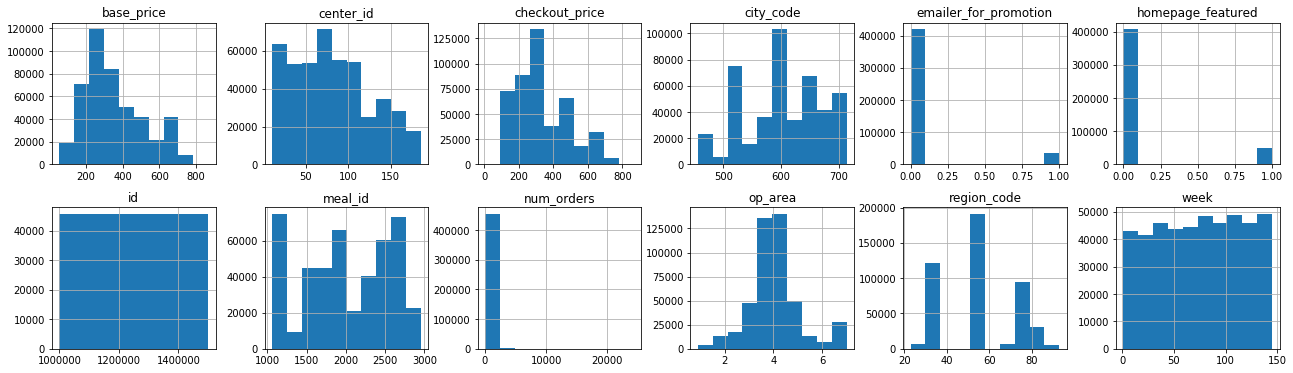

In [16]:
full_train[numerical].hist( figsize=(22, 6), layout=(2, 6));

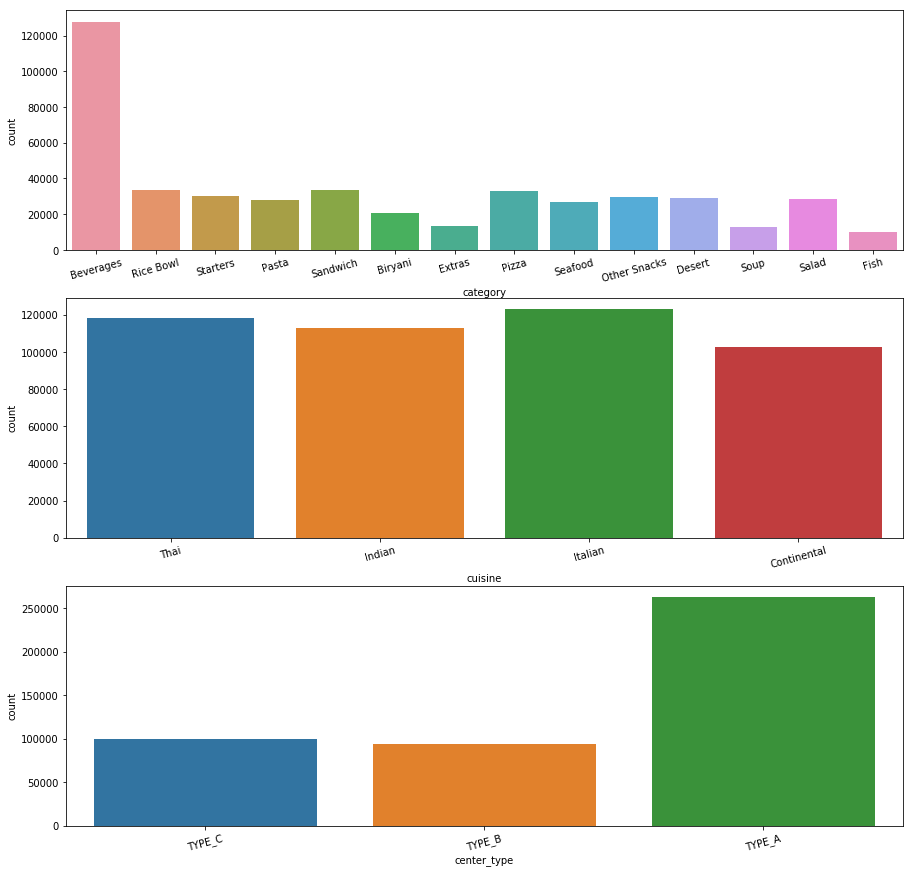

In [17]:
fig, ax = plt.subplots(3, 1, figsize=(15, 15))
for variable, subplot in zip(categorical, ax.flatten()):
    sns.countplot(full_train[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(15)

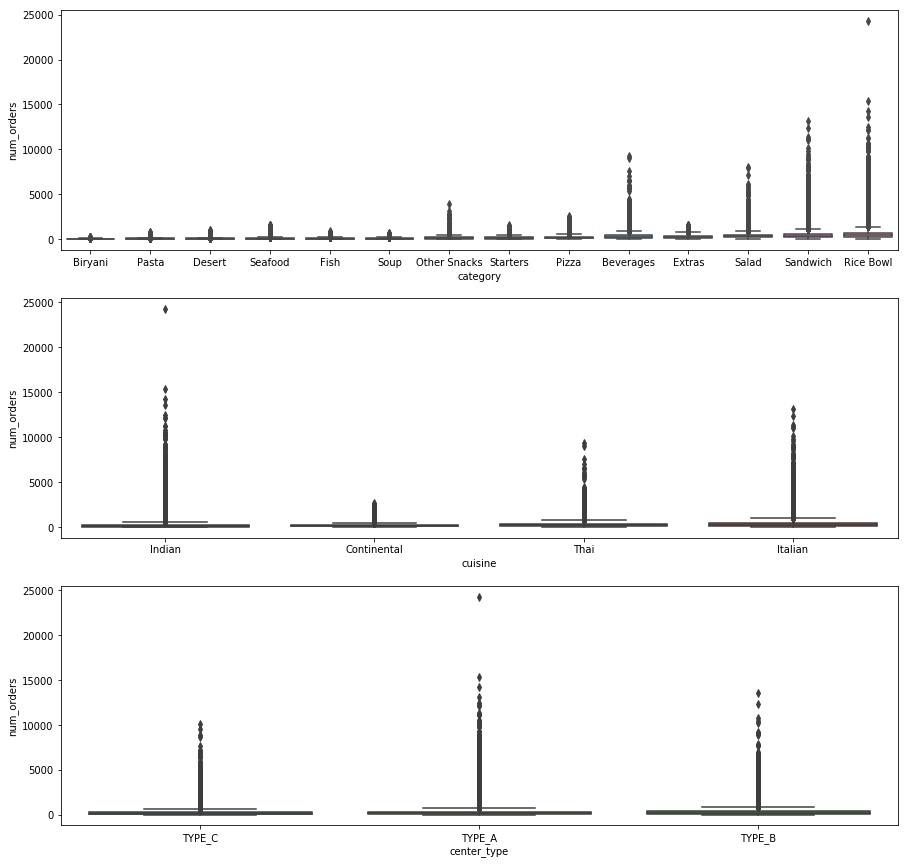

In [18]:
fig, ax = plt.subplots(3, 1, figsize=(15, 15))
for var, subplot in zip(categorical, ax.flatten()):
    sorted_vals = full_train.groupby([var])['num_orders'].median().sort_values()
    sns.boxplot(x=var, y='num_orders', data=full_train, ax=subplot, order=list(sorted_vals.index))

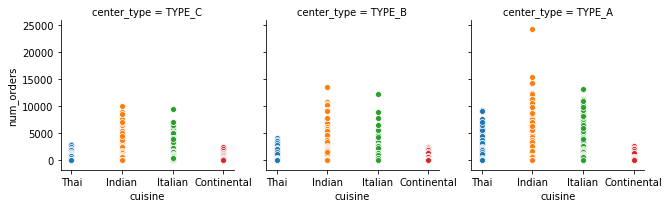

In [19]:
cond_plot = sns.FacetGrid(data=full_train, col='center_type', hue='cuisine', col_wrap=4)
cond_plot.map(sns.scatterplot, 'cuisine', 'num_orders');

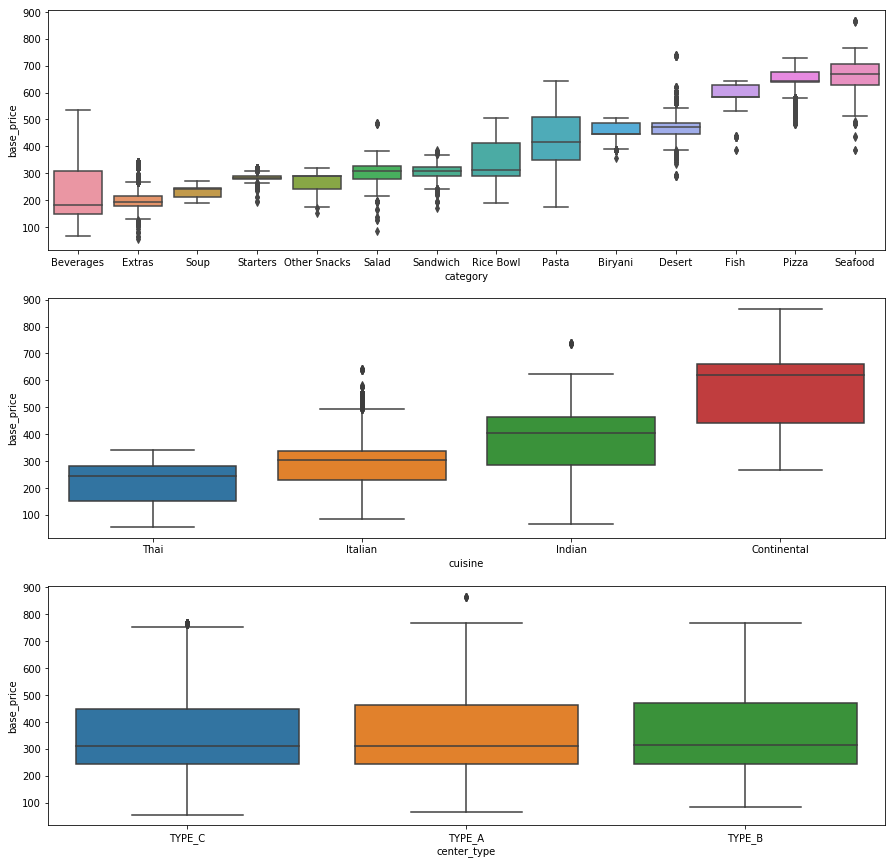

In [20]:
fig, ax = plt.subplots(3, 1, figsize=(15, 15))
for var, subplot in zip(categorical, ax.flatten()):
    sorted_vals = full_train.groupby([var])['base_price'].median().sort_values()
    sns.boxplot(x=var, y='base_price', data=full_train, ax=subplot, order=list(sorted_vals.index))

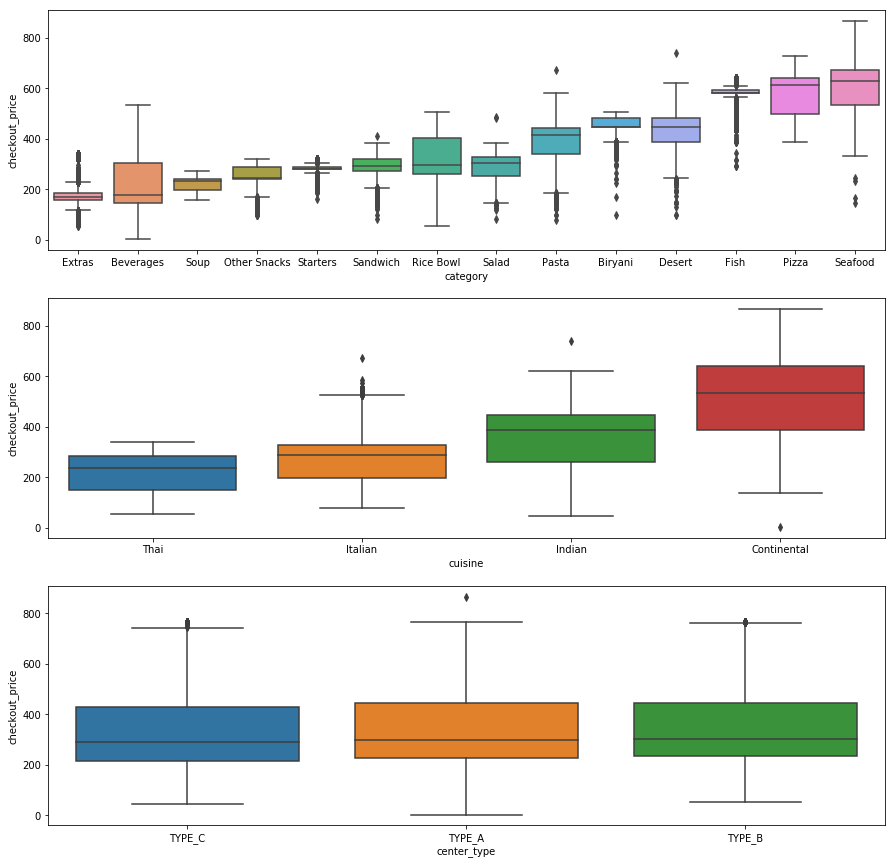

In [21]:
fig, ax = plt.subplots(3, 1, figsize=(15, 15))
for var, subplot in zip(categorical, ax.flatten()):
    sorted_vals = full_train.groupby([var])['checkout_price'].median().sort_values()
    sns.boxplot(x=var, y='checkout_price', data=full_train, ax=subplot, order=list(sorted_vals.index))

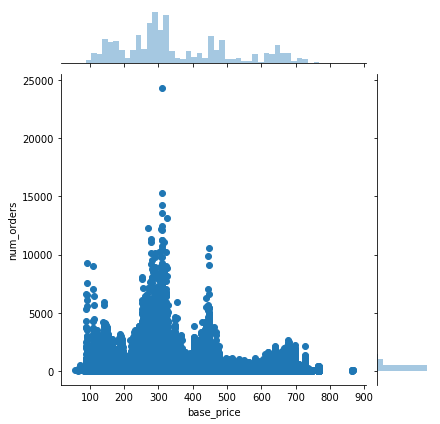

In [22]:
sns.jointplot(x=full_train['base_price'], y=full_train['num_orders']);

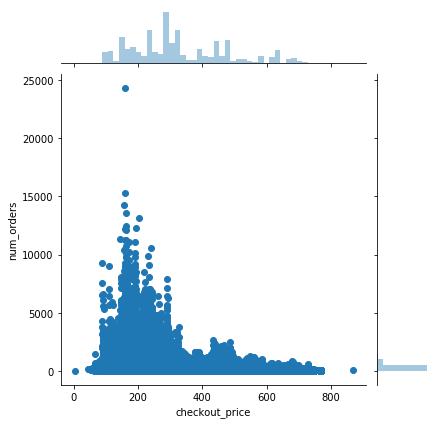

In [23]:
sns.jointplot(x=full_train['checkout_price'], y=full_train['num_orders']);

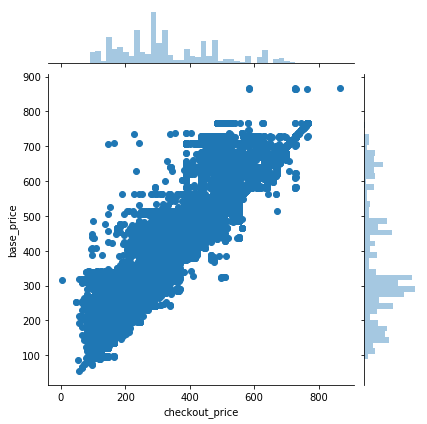

In [24]:
sns.jointplot(x=full_train['checkout_price'], y=full_train['base_price']);

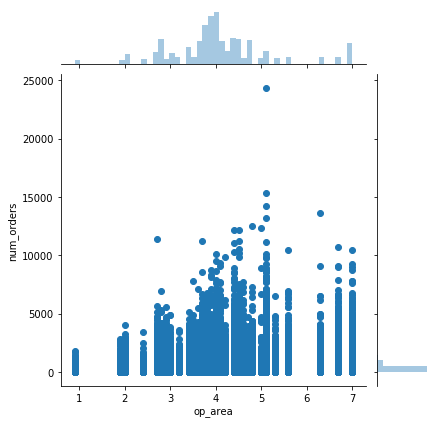

In [25]:
sns.jointplot(x=full_train['op_area'], y=full_train['num_orders']);

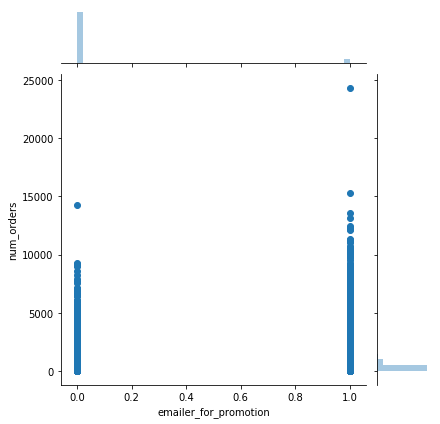

In [26]:
sns.jointplot(x=full_train['emailer_for_promotion'], y=full_train['num_orders']);

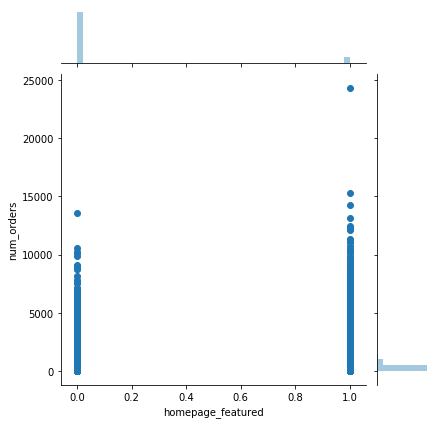

In [27]:
sns.jointplot(x=full_train['homepage_featured'], y=full_train['num_orders']);

In [28]:
display_all(full_train.isnull().sum().sort_index()/len(full_train))

base_price              0.000
category                0.000
center_id               0.000
center_type             0.000
checkout_price          0.000
city_code               0.000
cuisine                 0.000
emailer_for_promotion   0.000
homepage_featured       0.000
id                      0.000
meal_id                 0.000
num_orders              0.000
op_area                 0.000
region_code             0.000
week                    0.000
dtype: float64

### Feature Engineering

In [29]:
full_data = full_train.append(full_test)

In [30]:
display_all(full_data.tail())

base_price category  center_id center_type  checkout_price  city_code  \
32568     484.090   Desert         61      TYPE_A         482.090        473   
32569     483.090   Desert         61      TYPE_A         483.090        473   
32570     323.070    Salad         61      TYPE_A         322.070        473   
32571     323.070    Salad         61      TYPE_A         322.070        473   
32572     276.450    Salad         61      TYPE_A         276.450        473   

       cuisine  emailer_for_promotion  homepage_featured       id  meal_id  \
32568   Indian                      0                  0  1250239     1543   
32569   Indian                      0                  0  1039516     2304   
32570  Italian                      0                  0  1158107     2664   
32571  Italian                      0                  0  1444235     2569   
32572  Italian                      0                  0  1291286     2490   

       num_orders  op_area  region_code  week  
32568         nan    4.500           77   155  
32569         nan    4.500           77   155  
32570         nan    4.500           77   155  
32571         nan    4.500           77   155  
32572         nan    4.500           77   155

In [31]:
full_data['discount_avail'] = np.where(full_data['checkout_price'] > full_data['base_price']
                                      ,'no'
                                      ,np.where(full_data['base_price'] > full_data['checkout_price']
                                               ,'yes'
                                               ,'same')
                                      )

In [32]:
full_data['discount_rate'] = np.where(full_data['base_price'] > full_data['checkout_price']
                                      ,round(100*(full_data['base_price'] - full_data['checkout_price'])
                                             /full_data['base_price'],2)
                                      ,0
                                      )

In [33]:
full_data['surcharge'] = np.where(full_data['checkout_price'] > full_data['base_price']
                                      ,round(100*(full_data['checkout_price'] - full_data['base_price'])
                                             /full_data['checkout_price'],2)
                                      ,0
                                      )

In [34]:
full_data['price_diff'] = full_data['checkout_price'] - full_data['base_price']

In [35]:
full_data['promo_combo'] = full_data['emailer_for_promotion'] + full_data['homepage_featured']

In [36]:
full_data['op_area_disc'] = full_data['discount_rate']*full_data['op_area']

In [37]:
full_data['op_area_surch'] = full_data['surcharge']*full_data['op_area']

In [38]:
full_data['op_area_promo'] = full_data['promo_combo']*full_data['op_area']

In [39]:
train_df = full_data[:len(train_data)]

In [40]:
test_df = full_data[len(train_data):]

In [41]:
train_df['week_num']=train_df.week%52
test_df['week_num']=test_df.week%52

train_df['week_num'] = np.where(train_df['week_num'] == 0 ,52, train_df['week_num'])
test_df['week_num'] = np.where(test_df['week_num'] == 0 ,52, test_df['week_num'])

In [42]:
center_meal_df = calc_smooth_mean(train_df, ['center_id', 'meal_id'], 'num_orders', 300).reset_index()
center_meal_df.rename(index=str,columns={0:'cen_meal_orders'}, inplace=True)

In [43]:
center_category_df = calc_smooth_mean(train_df, ['center_id', 'category'], 'num_orders', 300).reset_index()
center_category_df.rename(index=str,columns={0:'cen_cat_orders'}, inplace=True)

In [44]:
center_cuisine_df = calc_smooth_mean(train_df, ['center_id', 'cuisine'], 'num_orders', 300).reset_index()
center_cuisine_df.rename(index=str,columns={0:'cen_cus_orders'}, inplace=True)

In [45]:
promo_disc_df = calc_smooth_mean(train_df, ['promo_combo'
                                            , 'discount_avail'
                                            , 'category'
                                           ], 'num_orders', 300).reset_index()
promo_disc_df.rename(index=str,columns={0:'promo_disc_orders'}, inplace=True)

In [46]:
city_reg_cent_df = calc_smooth_mean(train_df, ['city_code'
                                              , 'region_code'
                                              , 'center_type'
                                              ], 'num_orders', 300).reset_index()
city_reg_cent_df.rename(index=str,columns={0:'city_reg_cent_orders'}, inplace=True)

In [47]:
centype_cat_cus_df = calc_smooth_mean(train_df, ['center_type'
                                                , 'category'
                                                , 'cuisine'
                                                ], 'num_orders', 300).reset_index()
centype_cat_cus_df.rename(index=str,columns={0:'centype_cat_cus_orders'}, inplace=True)

In [48]:
train_df  = pd.merge(train_df, center_category_df, how="left", on=['center_id', 'category'])
train_df  = pd.merge(train_df, center_meal_df, how="left", on=['center_id', 'meal_id'])
train_df  = pd.merge(train_df, center_cuisine_df, how="left", on=['center_id', 'cuisine'])
train_df  = pd.merge(train_df, promo_disc_df, how="left", on=['promo_combo', 'discount_avail' ,'category'])
train_df  = pd.merge(train_df, city_reg_cent_df, how="left", on=['city_code', 'region_code' ,'center_type'])
train_df  = pd.merge(train_df, centype_cat_cus_df, how="left", on=['center_type', 'category' ,'cuisine'])

In [49]:
test_df  = pd.merge(test_df, center_category_df, how="left", on=['center_id', 'category'])
test_df  = pd.merge(test_df, center_meal_df, how="left", on=['center_id', 'meal_id'])
test_df  = pd.merge(test_df, center_cuisine_df, how="left", on=['center_id', 'cuisine'])
test_df  = pd.merge(test_df, promo_disc_df, how="left", on=['promo_combo', 'discount_avail','category'])
test_df  = pd.merge(test_df, city_reg_cent_df, how="left", on=['city_code', 'region_code' ,'center_type'])
test_df  = pd.merge(test_df, centype_cat_cus_df, how="left", on=['center_type', 'category' ,'cuisine'])

In [50]:
train_df, test_df = get_count_encode(train_df,test_df,['week_num','center_id'],'id','count_week_center')
train_df, test_df = get_count_encode(train_df,test_df,['week_num','meal_id'],'id','count_week_meal')

In [51]:
train_df.shape, train_data.shape, test_df.shape, test_data.shape

((456548, 32), (456548, 11), (32573, 32), (32573, 10))

In [52]:
display_all(100*train_df.isnull().sum().sort_index()/len(train_df))

base_price               0.000
category                 0.000
cen_cat_orders           0.000
cen_cus_orders           0.000
cen_meal_orders          0.000
center_id                0.000
center_type              0.000
centype_cat_cus_orders   0.000
checkout_price           0.000
city_code                0.000
city_reg_cent_orders     0.000
count_week_center        0.000
count_week_meal          0.000
cuisine                  0.000
discount_avail           0.000
discount_rate            0.000
emailer_for_promotion    0.000
homepage_featured        0.000
id                       0.000
meal_id                  0.000
num_orders               0.000
op_area                  0.000
op_area_disc             0.000
op_area_promo            0.000
op_area_surch            0.000
price_diff               0.000
promo_combo              0.000
promo_disc_orders        0.000
region_code              0.000
surcharge                0.000
week                     0.000
week_num                 0.000
dtype: f

In [53]:
display_all(100*test_df.isnull().sum().sort_index()/len(test_df))

base_price                 0.000
category                   0.000
cen_cat_orders             0.040
cen_cus_orders             0.000
cen_meal_orders            0.040
center_id                  0.000
center_type                0.000
centype_cat_cus_orders     0.000
checkout_price             0.000
city_code                  0.000
city_reg_cent_orders       0.000
count_week_center          0.000
count_week_meal            0.000
cuisine                    0.000
discount_avail             0.000
discount_rate              0.000
emailer_for_promotion      0.000
homepage_featured          0.000
id                         0.000
meal_id                    0.000
num_orders               100.000
op_area                    0.000
op_area_disc               0.000
op_area_promo              0.000
op_area_surch              0.000
price_diff                 0.000
promo_combo                0.000
promo_disc_orders          0.000
region_code                0.000
surcharge                  0.000
week      

In [54]:
Train = train_df.copy(deep=True)
Test = test_df.copy(deep=True)

In [55]:
train_cats(train_df)

In [56]:
apply_cats(test_df, train_df)

In [57]:
df, y, nas = proc_df(train_df, 'num_orders', skip_flds=['id'])
df_test, _, nas = proc_df(test_df, 'num_orders', skip_flds=['id'])

In [58]:
display_all(df.head())

base_price  category  center_id  center_type  checkout_price  city_code  \
0     152.290         1         55            3         136.830        647   
1     135.830         1         55            3         136.830        647   
2     135.860         1         55            3         134.860        647   
3     437.530         1         55            3         339.500        647   
4     242.500         1         55            3         243.500        647   

   cuisine  emailer_for_promotion  homepage_featured  meal_id  op_area  \
0        4                      0                  0     1885    2.000   
1        4                      0                  0     1993    2.000   
2        4                      0                  0     2539    2.000   
3        2                      0                  0     2139    2.000   
4        2                      0                  0     2631    2.000   

   region_code  week  discount_avail  discount_rate  surcharge  price_diff  \
0           56     1               3         10.150      0.000     -15.460   
1           56     1               1          0.000      0.730       1.000   
2           56     1               3          0.740      0.000      -1.000   
3           56     1               3         22.410      0.000     -98.030   
4           56     1               1          0.000      0.410       1.000   

   promo_combo  op_area_disc  op_area_surch  op_area_promo  week_num  \
0            0        20.300          0.000          0.000         1   
1            0         0.000          1.460          0.000         1   
2            0         1.480          0.000          0.000         1   
3            0        44.820          0.000          0.000         1   
4            0         0.000          0.820          0.000         1   

   cen_cat_orders  cen_meal_orders  cen_cus_orders  promo_disc_orders  \
0         191.066          251.593         151.683            275.620   
1         191.066          257.018         151.683            263.080   
2         191.066          238.743         151.683            275.620   
3         191.066          201.404         174.910            275.620   
4         191.066          199.843         174.910            263.080   

   city_reg_cent_orders  centype_cat_cus_orders  count_week_center  \
0               168.896                 280.842                112   
1               168.896                 280.842                112   
2               168.896                 280.842                112   
3               168.896                  76.711                112   
4               168.896                  76.711                112   

   count_week_meal  
0              230  
1              231  
2              216  
3              189  
4              219

In [59]:
display_all(df_test.head())

base_price  category  center_id  center_type  checkout_price  city_code  \
0     159.110         1         55            3         158.110        647   
1     159.110         1         55            3         160.110        647   
2     159.140         1         55            3         157.140        647   
3     162.020         1         55            3         162.020        647   
4     163.930         1         55            3         163.930        647   

   cuisine  emailer_for_promotion  homepage_featured  meal_id  op_area  \
0        4                      0                  0     1885    2.000   
1        4                      0                  0     1993    2.000   
2        4                      0                  0     2539    2.000   
3        2                      0                  0     2631    2.000   
4        2                      0                  0     1248    2.000   

   region_code  week  discount_avail  discount_rate  surcharge  price_diff  \
0           56   146               3          0.630      0.000      -1.000   
1           56   146               1          0.000      0.620       1.000   
2           56   146               3          1.260      0.000      -2.000   
3           56   146               2          0.000      0.000       0.000   
4           56   146               2          0.000      0.000       0.000   

   promo_combo  op_area_disc  op_area_surch  op_area_promo  week_num  \
0            0         1.260          0.000          0.000        42   
1            0         0.000          1.240          0.000        42   
2            0         2.520          0.000          0.000        42   
3            0         0.000          0.000          0.000        42   
4            0         0.000          0.000          0.000        42   

   cen_cat_orders  cen_meal_orders  cen_cus_orders  promo_disc_orders  \
0         191.066          251.593         151.683            275.620   
1         191.066          257.018         151.683            263.080   
2         191.066          238.743         151.683            275.620   
3         191.066          199.843         174.910            261.925   
4         191.066          198.316         174.910            261.925   

   city_reg_cent_orders  centype_cat_cus_orders  count_week_center  \
0               168.896                 280.842                 70   
1               168.896                 280.842                 70   
2               168.896                 280.842                 70   
3               168.896                  76.711                 70   
4               168.896                  76.711                 70   

   count_week_meal  
0              153  
1              153  
2              138  
3              147  
4              137

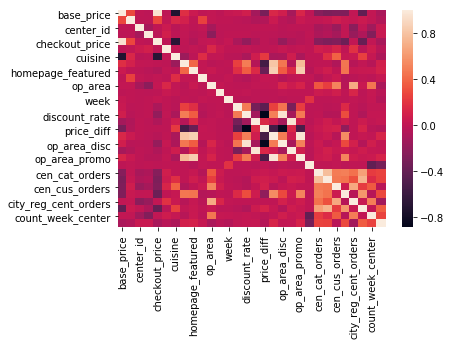

In [60]:
sns.heatmap(df.corr())

In [61]:
n_valid = 32573  # same as test set size
n_trn = len(df)-n_valid
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((423975, 30), (423975,), (32573, 30))

In [62]:
def print_score(m):
    res = [rmsle(m.predict(X_train), y_train), rmsle(m.predict(X_valid), y_valid),
                round(m.score(X_train, y_train),3), round(m.score(X_valid, y_valid),3)]
    if hasattr(m, 'oob_score_'): res.append(round(m.oob_score_,3))
    print(res)

### Model Building

In [63]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
%time rf.fit(X_train, y_train)
print_score(rf)

CPU times: user 15min 10s, sys: 7.4 s, total: 15min 17s
Wall time: 2min 19s
[21.792, 53.65, 0.984, 0.812, 0.884]


### Random Forest Model

In [64]:
rf = RandomForestRegressor(n_estimators=750, min_samples_leaf=6, max_features=0.5, n_jobs=-1, oob_score=True)
%time rf.fit(X_train, y_train)
print_score(rf)

CPU times: user 56min 45s, sys: 24.9 s, total: 57min 10s
Wall time: 8min 34s
[38.008, 50.632, 0.93, 0.847, 0.881]


In [65]:
sorted(zip(rf.feature_importances_,X_train),reverse=True)

[(0.4193270280995104, 'cen_meal_orders'),
 (0.1498423971426719, 'promo_disc_orders'),
 (0.059651574273615754, 'centype_cat_cus_orders'),
 (0.057047330259333354, 'op_area_promo'),
 (0.04552610699229973, 'cen_cat_orders'),
 (0.041517478159989865, 'discount_rate'),
 (0.03689933422828031, 'checkout_price'),
 (0.025470988569416753, 'promo_combo'),
 (0.024279465771538607, 'op_area_disc'),
 (0.02223418564774298, 'week'),
 (0.01685096784615165, 'week_num'),
 (0.015404431466428453, 'emailer_for_promotion'),
 (0.01386102966252209, 'price_diff'),
 (0.012213832307039247, 'base_price'),
 (0.010557834869434565, 'cen_cus_orders'),
 (0.008439184414599716, 'count_week_center'),
 (0.008147068843976353, 'count_week_meal'),
 (0.006659034679634584, 'city_reg_cent_orders'),
 (0.0060454449664639354, 'meal_id'),
 (0.0038214357356504713, 'category'),
 (0.003116627945990457, 'center_id'),
 (0.002778018793325973, 'homepage_featured'),
 (0.002708485794972028, 'op_area'),
 (0.002408310388272578, 'city_code'),
 (0.

In [73]:
err=[]
y_pred_all=[]
fold=KFold(n_splits=5, shuffle=True, random_state=1994)
for train_idx, test_idx in fold.split(df, y):
    X_train, X_test = df.iloc[train_idx], df.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    model = RandomForestRegressor(n_estimators=1000
                               , min_samples_leaf=6
                               , max_features=0.5
                               , n_jobs=-1
                               , oob_score=True
                               , verbose=1
                              )
    model.fit(X_train,y_train)
    preds=model.predict(X_test)
    print("rmsle: ",rmsle(preds, y_test))
    err.append(rmsle(preds, y_test))
    p = model.predict(df_test)
    y_pred_all.append(p)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 19.9min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    6.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:   11.5s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:   15.0s finished


rmsle:  47.38


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    3.5s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    4.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   51.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 16.9min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.3s


rmsle:  47.324


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 10.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.7s


rmsle:  47.526


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  7.9min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.8s


rmsle:  47.445


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  8.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.8s


rmsle:  47.098


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    1.9s finished


In [74]:
print(np.mean(err,0))

47.354600000000005


In [75]:
y_pred_all

[array([144.57028, 154.21751, 170.361  , ..., 304.16239, 387.07891, 192.03975]),
 array([152.08608, 156.43713, 163.49501, ..., 293.73115, 388.408  , 186.5256 ]),
 array([160.89477, 172.20706, 168.49219, ..., 290.63053, 397.97347, 186.94161]),
 array([147.78123, 148.66983, 167.11883, ..., 299.54074, 383.17524, 188.32428]),
 array([145.79652, 152.89389, 170.53817, ..., 294.98464, 388.62414, 184.63689])]

In [76]:
submission=pd.DataFrame({'id':full_test['id']
                         ,'num_orders':np.mean(y_pred_all,0)
                        })
submission['num_orders'] = np.floor(submission['num_orders'])
submission.head()

id  num_orders
0  1028232     150.000
1  1127204     156.000
2  1212707     168.000
3  1082698      42.000
4  1400926      40.000

In [77]:
file_timestamp = datetime.now().strftime('%m%d%Y_%H%M')
submission.to_csv(f'./data/food_forecasting/Submission_{file_timestamp}.csv', index=False)

### Useful functions / code for reference

In [78]:
# err_lgb=[]
# y_pred_tot_lgb=[]
# fold=KFold(n_splits=5, shuffle=True, random_state=1994)
# for train_idx, test_idx in fold.split(df, y):
#     X_train, X_test = df.iloc[train_idx], df.iloc[test_idx]
#     y_train, y_test = y[train_idx], y[test_idx]
#     params = {
#         "objective" : "regression",
#         "metric" : "rmse",
#         "boosting": "gbdt",
#         "num_leaves" : 100,
#         "max_depth" : 25,
#         "min_child_weight" : 50,
#         "learning_rate" : 0.05,
#         "bagging_fraction" : 0.7,
#         "feature_fraction" : 0.9,
#         "bagging_frequency" : 5,
#         "bagging_seed" : 7979,
#         "verbosity" : -1
#     }
#     lgtrain = lgb.Dataset(X_train, y_train)
#     lgval = lgb.Dataset(X_test, y_test)
#     evals_result = {}
#     model = lgb.train(params
#                       , lgtrain
#                       , 3000
#                       , valid_sets=[lgval]
#                       , early_stopping_rounds=100
#                       , verbose_eval=100
#                       , evals_result=evals_result
#                      )
#     preds=model.predict(X_test, num_iteration=model.best_iteration)
#     preds[preds < 0] = 0
#     print("rmsle: ",rmsle(preds, y_test))
#     err_lgb.append(rmsle(preds, y_test))
#     p = model.predict(df_test, num_iteration=model.best_iteration)
#     p[p < 0] = 0
#     y_pred_tot_lgb.append(p)

In [79]:
# fig, ax = plt.subplots(figsize=(12,10))
# lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
# ax.grid(False)
# plt.title("LightGBM - Feature Importance", fontsize=15)
# plt.show()

In [80]:
# print(np.mean(err_lgb,0))

In [81]:
# y_pred_tot_lgb

In [82]:
# submission=pd.DataFrame({'id':full_test['id']
#                          ,'num_orders':np.mean(y_pred_tot_lgb,0)
#                         })
# submission['num_orders'] = np.floor(submission['num_orders'])
# submission.head()

In [83]:
# file_timestamp = datetime.now().strftime('%m%d%Y_%H%M')
# submission.to_csv(f'./data/food_forecasting/Submission_{file_timestamp}.csv', index=False)

In [84]:
# import xgboost as xgb
# from xgboost import plot_importance
# import lightgbm as lgbm

In [85]:
# dtrain = xgb.DMatrix(df, label=y)

In [86]:
# def train_xgb(max_depth=6,num_round=1000,seed=0):
#     param = {
#         'max_depth':max_depth,
#         'eta': 0.1,
#         'silent': 1, 
#         'objective': 'reg:linear',  
#         'eval_metric':'rmse',
#         'seed':seed

#     }  
#     num_round = num_round
#     bst= xgb.train(param, dtrain, num_round)
#     return bst

In [87]:
# %%time
# bst=train_xgb(6,1200,0)

In [88]:
# _,ax = plt.subplots(1,1,figsize=(5,5))
# plot_importance(bst,ax)

In [89]:
# def train_lgb(max_depth=5,seed=4,num_round=2500):
#     d_train = lgbm.Dataset(df,y)
#     params = {
#         'objective' :'regression',
#         'max_depth':max_depth,
#         'learning_rate' : 0.1,
#         'num_leaves' :(2*max_depth)-1 ,
#         'feature_fraction': 0.8,
#         "min_data_in_leaf" : 100,
#         'bagging_fraction': 0.7, 
#         'boosting_type' : 'gbdt',
#         'metric': 'rmse',
#         'seed':seed
#     }
#     lgb= lgbm.train(params, d_train, num_round)
#     return lgb

In [90]:
# lgb1=train_lgb(6,4,2500)

In [91]:
# _,ax = plt.subplots(1,1,figsize=(12,6))
# lgbm.plot_importance(lgb1,ax=ax)

In [92]:
# xgb_pred = bst.predict(xgb.DMatrix(df_test))

In [93]:
# lgb_pred = lgb1.predict(df_test)

In [94]:
# sub=pd.read_csv('./data/food_forecasting/sample_submisison.csv')

In [95]:
# sub.num_orders=0.6*xgb_pred+lgb_pred*0.4
# file_timestamp = datetime.now().strftime('%m%d%Y_%H%M')
# sub.to_csv(f'./data/food_forecasting/Submission_{file_timestamp}.csv', index=False)